In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict
from linearmodels.iv.results import compare
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from doubleml import DoubleMLData, DoubleMLClusterData, DoubleMLPLIV
from doubleml.utils import DMLDummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cylp4nc8 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def dml_rolling_window(filtered_data, base_covariates, manual_params_l=None, manual_params_r = None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable = 'consumption_normalized'):
    
    data = filtered_data.copy()
    
    covariates = base_covariates.copy()
    

    # Initialize lists to collect predictions and time indices
    predictions_ml_l = []
    predictions_ml_r = []
    predictions_ml_m = []
    time_indices = []
    train_predictions = []
    train_actuals = []
    test_predictions = []
    test_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    test_years = []
    fold_feature_importance_df = []
    fold_coefficients = []

    

    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]
    
    
    def tune_xgb_model(X, y, param_dist_xgb):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist", eval_metric="rmse")
        grid_search = GridSearchCV(model, param_dist_xgb, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_
        
    best_params_xgb = None  # Store best params from first window
    best_params_xgb_treat = None
    best_params_xgb_inst = None
    lasso_param = None
    
    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices

    
    
    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue
        
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")


        X_train = train_data[covariates]
        y_train_ml_l = train_data[dependent_variable]
        d_train_ml_r = train_data['DayAheadPriceEUR']
        z_train_ml_m_1 = train_data['Total_Wind_Generation']
        
        
        if best_params_xgb is None and manual_params_l is None:
            best_params_xgb = tune_xgb_model(X_train, y_train_ml_l, param_dist_xgb)
            print("Best L Parameters:", best_params_xgb)
        
        if best_params_xgb_treat is None and manual_params_r is None:
            best_params_xgb_treat = tune_xgb_model(X_train, d_train_ml_r, param_dist_xgb_r)
            print("Best R Parameters:", best_params_xgb_treat)
            
            
        if best_params_xgb_inst is None and manual_params_m is None:
            best_params_xgb_inst = tune_xgb_model(X_train, z_train_ml_m_1, param_dist_xgb_m)
            print("Best M Parameters:", best_params_xgb_inst)
            
        learner_l = xgb.XGBRegressor(**(manual_params_l if manual_params_l else best_params_xgb))
        learner_r = xgb.XGBRegressor(**(manual_params_r if manual_params_r else best_params_xgb_treat))
        learner_m = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_xgb_inst))
            # Train each model on the training set (fixed window)
        learner_l.fit(X_train, y_train_ml_l)
        learner_r.fit(X_train, d_train_ml_r)
        learner_m.fit(X_train, z_train_ml_m_1)
            
        feature_importances_per_window.append(learner_l.feature_importances_)

            # Predict on the test set (next year)
        X_test = test_data[covariates]
        y_test_ml_l = test_data[dependent_variable]
        d_test_ml_r = test_data['DayAheadPriceEUR']
        z_test_ml_m_1 = test_data['Total_Wind_Generation']
        pred_l = learner_l.predict(X_test)
        pred_r = learner_r.predict(X_test)
        pred_m = learner_m.predict(X_test)
            
            # Predict on the train set (next year)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train_ml_l)
        test_predictions.extend(learner_l.predict(X_test))
        test_actuals.extend(y_test_ml_l)

            # Append predictions and indices to the lists
        predictions_ml_l.extend(pred_l)
        predictions_ml_r.extend(pred_r)
        predictions_ml_m.extend(pred_m)
        time_indices.extend(test_data.index.tolist())
        
        plt.figure(figsize=(12, 4))
        plt.plot(test_actuals[:500], label='Actual')
        plt.plot(test_predictions[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()
        
        fold_mae = mean_absolute_error(y_test_ml_l, pred_l)
        fold_rmse = mean_squared_error(y_test_ml_l, pred_l, squared=False)
        fold_r2 = r2_score(y_test_ml_l, pred_l)
        fold_rr = r2_score(d_test_ml_r, pred_r)
        fold_rz = r2_score(z_test_ml_m_1, pred_m)
        print("Test error l:", fold_r2)
        print("Test error r:", fold_rr)
        print("Test error m:", fold_rz)
        
        fold_metrics.append({
            'Test Year': test_year,
            'MAE': fold_mae,
            'RMSE': fold_rmse,
            'R2': fold_r2
        })
        test_years.append(test_year)
        
        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))
        
        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols='DayAheadPriceEUR',
            z_cols='Total_Wind_Generation',
            x_cols=covariates,
            cluster_cols=['Country']
        )
        
        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'DayAheadPriceEUR': {
                'ml_l': pred_l.reshape(-1, 1),
                'ml_r': pred_r.reshape(-1, 1),
                'ml_m': pred_m.reshape(-1, 1)
            }
        })
        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })


    # Calculate metrics for the entire model
    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse = mean_squared_error(train_actuals, train_predictions, squared=False)
    train_r2 = r2_score(train_actuals, train_predictions)

    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
    test_r2 = r2_score(test_actuals, test_predictions)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")

    
    
    feature_importances_array = np.array(feature_importances_per_window)
    mean_importances = feature_importances_array.mean(axis=0)
    std_importances = feature_importances_array.std(axis=0)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': mean_importances,
        'Std Importance': std_importances
    }).sort_values(by='Mean Importance', ascending=False)
    

    # Convert predictions lists to numpy arrays
    filtered_data = data.loc[data.index.isin(time_indices)].copy()
    
    #### predictins dataset? original dataset?

    predictions_ml_l = np.array(predictions_ml_l).reshape(-1, 1)
    predictions_ml_r = np.array(predictions_ml_r).reshape(-1, 1)
    predictions_ml_m = np.array(predictions_ml_m).reshape(-1, 1)


    pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': predictions_ml_l,
            'ml_r': predictions_ml_r,
            'ml_m': predictions_ml_m
        }
    }

    # Initialize DoubleML data object
    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols='DayAheadPriceEUR',
        z_cols='Total_Wind_Generation',  # Use original instruments (not the lags) for DoubleML
        x_cols=covariates,
        cluster_cols=['Country']
    )
    # Use dummy regressors for DoubleML
    ml_l = dml.utils.DMLDummyRegressor()
    ml_m = dml.utils.DMLDummyRegressor()
    ml_r = dml.utils.DMLDummyRegressor()

    # Initialize and fit DoubleML with external predictions
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, ml_l, ml_m, ml_r)
    dml_pliv_obj.fit(external_predictions=pred_dict)

    print(dml_pliv_obj)
    filtered_data["Prrediction"] = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Residuals"] = dml_pliv_obj.predictions["ml_l"].ravel() - filtered_data[dependent_variable]
    importance_all_folds_df = pd.concat(fold_feature_importance_df, ignore_index=True)
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    
    
    return dml_pliv_obj, filtered_data, importance_df, fold_metrics_df, importance_all_folds_df, fold_coefficients

In [3]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def print_metrics(metrics, dataset_type):
    print(f"{dataset_type} Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")

def evaluate_predictions(predictions, true_values, target_name="TargetVariable", time_values=None):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        time_values (pd.Series): Time values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)
    
    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)
    
    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")
    
    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")
    
    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100
    
    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")
    
    # Extract years for coloring
    if time_values is not None:
        unique_years = time_values.unique()
        norm = mcolors.Normalize(vmin=min(unique_years), vmax=max(unique_years))
        cmap = cm.viridis
        colors = cmap(norm(time_values))
    else:
        colors = 'blue'  # Default color if no time_values provided
    
    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.scatter(true_values, predictions, c=colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()
    
    # Residuals plot
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()
    
    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [4]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import random
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)
    
    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)
    
    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")
    
    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")
    
    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100
    
    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")
    
    # Generate distinct colors for each unique country
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)
        
        # Generate a list of random, unique colors
        random.seed(42)  # Ensures reproducibility
        colors = [
            (random.random(), random.random(), random.random()) 
            for _ in range(num_countries)
        ]
        cmap = ListedColormap(colors)
        
        # Map each country to a unique color
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'  # Default color if no country_values provided
        color_mapping = None
    
    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Residuals plot
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [8]:
data_1 = pd.read_csv('/workspace/new_data/filtered_data_with_holidays_updated.csv', index_col=0)
data_1

Unnamed: 0                 Time PriceArea  ConsumptionValue  \
Unnamed: 0.1                                                                
0.0                  0.0  2015-01-01 01:00:00        CH            7654.0   
1.0                 17.0  2015-01-01 01:00:00        SK            2728.0   
2.0                 16.0  2015-01-01 01:00:00        SI            1045.0   
3.0                 15.0  2015-01-01 01:00:00        PT            5124.0   
4.0                 10.0  2015-01-01 01:00:00      DK_2            1305.0   
...                  ...                  ...       ...               ...   
NaN                  NaN  2025-01-01 00:00:00      SE_2            1791.0   
NaN                  NaN  2025-01-01 00:00:00      SE_3            9658.0   
NaN                  NaN  2025-01-01 00:00:00      SE_4            2146.0   
NaN                  NaN  2025-01-01 00:00:00        SI            1159.0   
NaN                  NaN  2025-01-01 00:00:00        SK            2524.0   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature    Year  \
Unnamed: 0.1                                                                   
0.0                      38.08          3.647062          267.706482  2015.0   
1.0                      22.06          3.991796          265.239655  2015.0   
2.0                      22.20          4.172168          265.189819  2015.0   
3.0                      47.33          6.417383          279.455658  2015.0   
4.0                      16.04         10.561893          276.635590  2015.0   
...                        ...               ...                 ...     ...   
NaN                       3.69          3.096981          262.690735  2025.0   
NaN                       2.47          7.332158          272.276581  2025.0   
NaN                       2.04         14.230573          276.445221  2025.0   
NaN                     129.07          3.418118          274.394440  2025.0   
NaN                     138.56          6.014961          268.740997  2025.0   

              Month  Day  ...         YearMonthDay  Price_Area  Price_gas  \
Unnamed: 0.1              ...                                               
0.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
1.0             1.0  1.0  ...           2015-01-01          cz     20.650   
2.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
3.0             1.0  1.0  ...           2015-01-01          cz     20.650   
4.0             1.0  1.0  ...           2015-01-01         etf     20.650   
...             ...  ...  ...                  ...         ...        ...   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00        cegh     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00          cz     48.889   

              Price_coal  Price_EUA IsHoliday  B16  B18     B19 Price_gas_ttf  
Unnamed: 0.1                                                                   
0.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
1.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
2.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
3.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
4.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
...                  ...        ...       ...  ...  ...     ...           ...  
NaN                114.5      73.00       NaN  0.0  NaN   243.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN  2131.0           NaN  
NaN                114.5      73.00       NaN  1.0  NaN  1849.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN     0.0           NaN  
NaN      

In [9]:
# Convert 'Time' to datetime just to be sure
data_1['Time'] = pd.to_datetime(data_1['Time'])

# Full list of rows to remove
rows_to_remove = [
    ("2022-02-10 20:00:00", "SE_2"),
    ("2022-02-10 21:00:00", "SE_2"),
    ("2022-02-10 22:00:00", "SE_2"),
    ("2020-02-27 09:00:00", "DK_2"),
    ("2024-10-22 14:00:00", "DK_2"),
    ("2017-05-08 07:00:00", "DK_1"),
    ("2018-02-06 12:00:00", "DK_2"),
    ("2021-12-17 18:00:00", "IT_CALA"),
    ("2021-12-20 08:00:00", "IT_CALA"),
    ("2021-12-20 15:00:00", "IT_CALA"),
    ("2022-01-25 08:00:00", "IT_CALA"),
    ("2021-12-20 19:00:00", "IT_CALA"),
    ("2017-05-08 06:00:00", "DK_1"),
    ("2021-11-29 16:00:00", "IT_CALA"),
    ("2021-12-17 16:00:00", "IT_CALA"),
]
# Filter out the rows
for time_str, country in rows_to_remove:
    timestamp = pd.to_datetime(time_str)
    data_1 = data_1[~((data_1['Time'] == timestamp) & (data_1['PriceArea'] == country))]


# One lag

In [17]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] / 
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])['ConsumptionValue']
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['Lag1_Price'] = data.groupby('Country')['DayAheadPriceEUR'].shift(1)
    data['RollingStd24_LaggedPrice'] = data.groupby(['Country', 'Year'])['Lag1_Price'].transform(
        lambda x: x.rolling(window=24, min_periods=12).std()
    )
    price_threshold = data['Lag1_Price'].quantile(0.95)
    data['LaggedPriceSpike'] = (data['Lag1_Price'] > price_threshold).astype(int)


    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

        
    # Step 3: Optionally add lagged features
    lag_features = []
    if include_lags:
        data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
        lag_features = ['Lag1_Consumption']

    # Step 4: Define covariates
    if base_covariates is None:
        base_covariates = []
        
    all_features = base_covariates + lag_features

    for feat in all_features:
        if feat not in base_covariates:
            base_covariates.append(feat)

    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    endogenous_variable = 'DayAheadPriceEUR'
    instrument_variables = ['Total_Wind_Generation']

    key_variables = [dependent_variable, endogenous_variable] + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [18]:
processed_data_new, covariates_new = prepare_data_with_dummies_and_interactions(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)
processed_data_new = processed_data_new[processed_data_new['Time'].dt.year != 2025]
processed_data_new

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
21.0                28.0 2015-01-01 02:00:00           5879.00   
19.0                20.0 2015-01-01 02:00:00          21286.00   
18.0                23.0 2015-01-01 02:00:00           1745.00   
17.0                22.0 2015-01-01 02:00:00           1236.00   
20.0                26.0 2015-01-01 02:00:00           7397.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00            547.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
21.0                     20.27          5.878027          271.040405  2015   
19.0                     42.27          6.516034          278.325043  2015   
18.0                     14.60         11.060371          278.674744  2015   
17.0                     14.60         10.920368          277.208038  2015   
20.0                     35.47          3.526751          268.095337  2015   
...                        ...               ...                 ...   ...   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                     138.70          1.776654          284.461456  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  block_4.0:tempbin  \
Unnamed: 0.1                                    ...                      
21.0           1.0   2.0             28.202729  ...                0.0   
19.0           1.0   2.0             41.315077  ...                0.0   
18.0           1.0   2.0             41.944539  ...                0.0   
17.0           1.0   2.0             39.304469  ...                0.0   
20.0           1.0   2.0             22.901606  ...                0.0   
...            ...   ...                   ...  ...                ...   
NaN           31.0  23.0             50.992439  ...                0.0   
NaN           31.0  23.0             39.085511  ...                0.0   
NaN           31.0  23.0             25.749757  ...                0.0   
NaN           31.0  23.0             52.360621  ...                0.0   
NaN           31.0  23.0             39.424275  ...                0.0   

              block_4.0:tempbin2  block_4.0:Solar_MWh block_5.0:tempbin  \
Unnamed: 0.1                                                              
21.0                         0.0                  0.0               0.0   
19.0                         0.0                  0.0               0.0   
18.0                         0.0                  0.0               0.0   
17.0                         0.0                  0.0               0.0   
20.0                         0.0                  0.0               0.0   
...                          ...                  ...               ...   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   

              block_5.0:tempbin2  block_5.0:Solar_MWh block_6.0:tempbin  \
Unnamed: 0.1                                                              
21.0                         0.0                  0

In [32]:
manual_params_l = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.02,
    'max_depth': 5,
    'n_estimators': 400,
    'subsample': 0.8
}

manual_params_r = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'subsample': 0.7
}

manual_params_m = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.01,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 0.9
}



Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401794 | Test samples: 209955


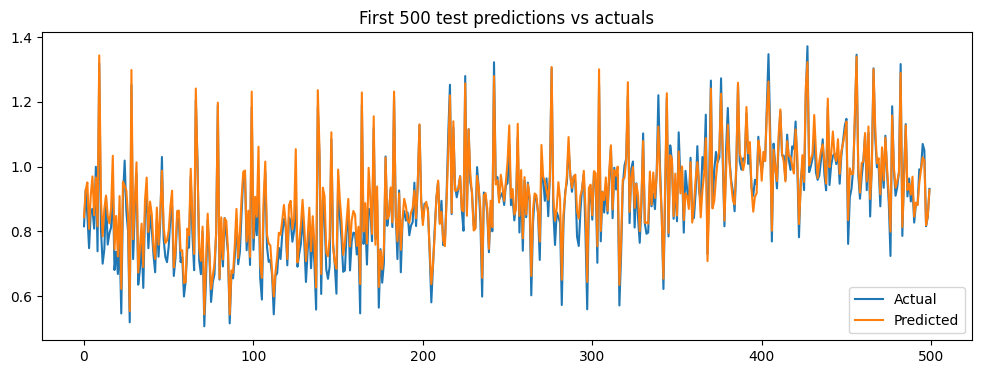

Test error l: 0.9653527303989429
Test error r: 0.23606443992501258
Test error m: 0.5585294888746647

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412296 | Test samples: 203208


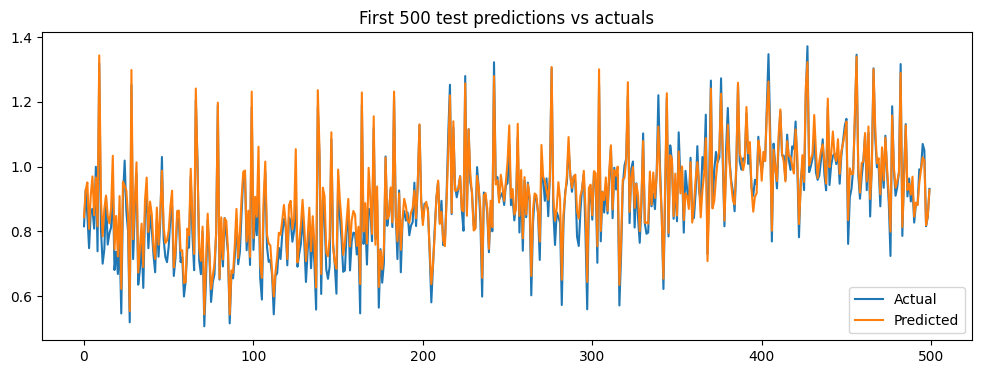

Test error l: 0.9618865437513308
Test error r: -0.011715271498206503
Test error m: 0.5888173786328135

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221270


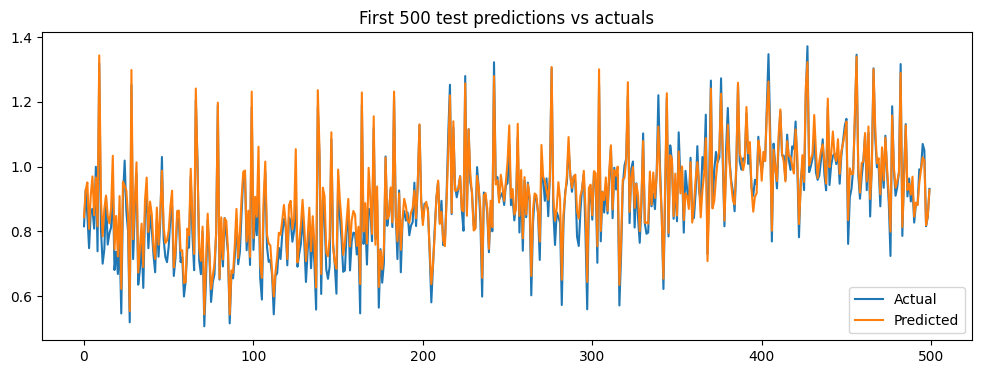

Test error l: 0.9660035062371372
Test error r: 0.25971896651093973
Test error m: 0.45644856499177366

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424478 | Test samples: 234724


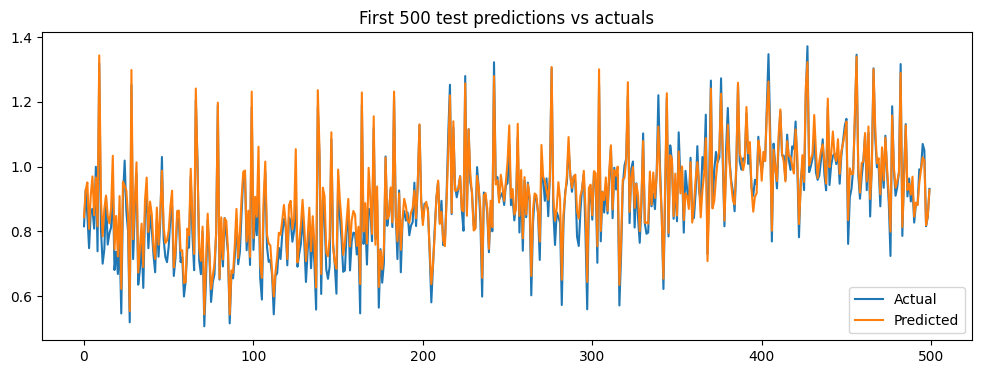

Test error l: 0.9689843499633508
Test error r: 0.14761265916749033
Test error m: 0.6022198827006577

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455994 | Test samples: 252358


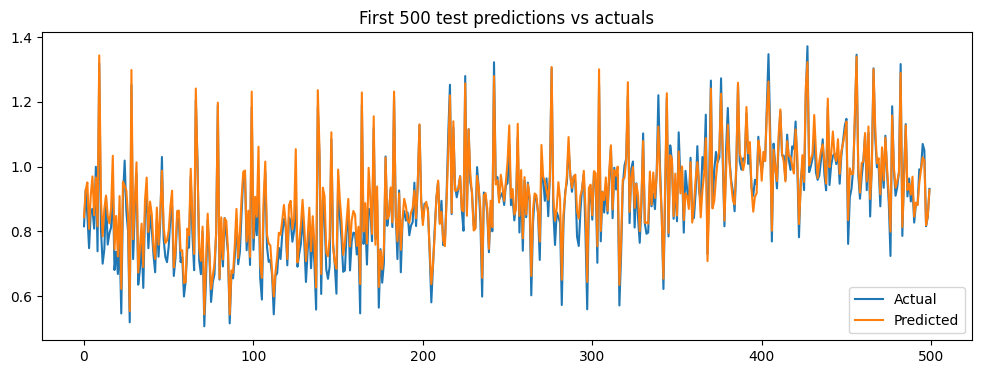

Test error l: 0.95184753682884
Test error r: -0.6061031846247789
Test error m: 0.3621828613902751

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487082 | Test samples: 282858


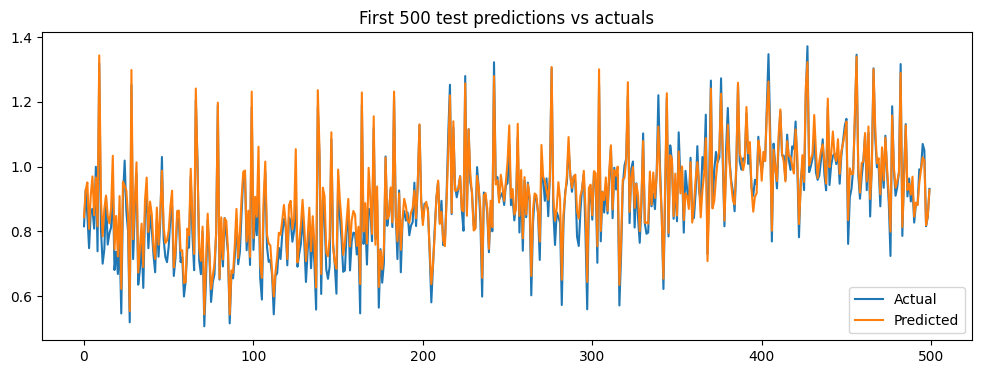

Test error l: 0.953557345338072
Test error r: 0.30719028036312435
Test error m: 0.6429555596131293

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535216 | Test samples: 289869


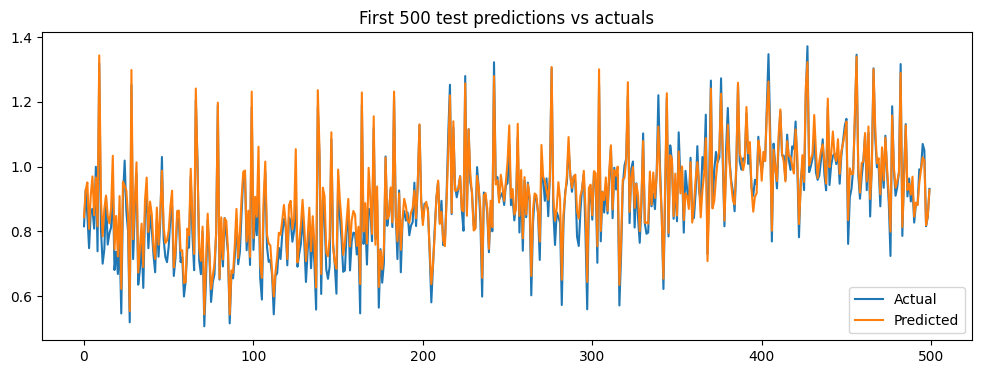

Test error l: 0.9556618029190963
Test error r: 0.2234509085660471
Test error m: 0.574789392755151

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572727 | Test samples: 304063


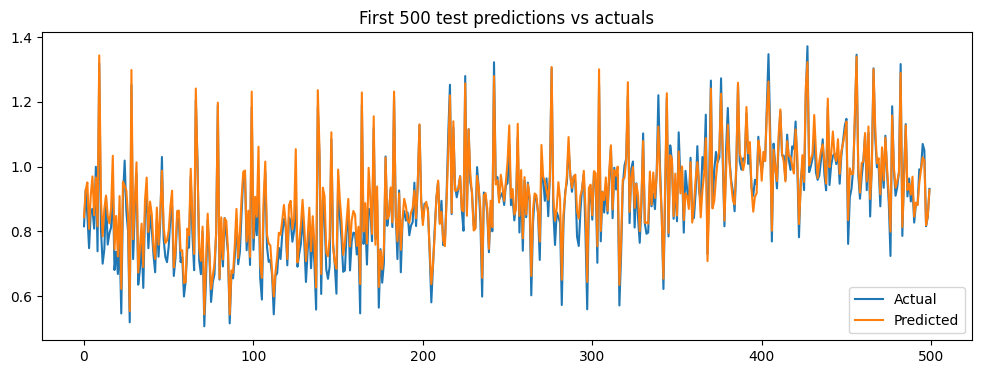

Test error l: 0.958002450468875
Test error r: 0.15169158199707344
Test error m: 0.6201565646800883
Overall Train Metrics:
MAE: 0.026119817068357053, RMSE: 0.036282202914590694, R²: 0.9641291991488019
Overall Test Metrics:
MAE: 0.027721378310246427, RMSE: 0.03928217469535933, R²: 0.9594251173405794
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_81', 'HourOfWeek_120', 'HourOfWeek_48', 'block_6.0:Solar_MWh', 'HourOfWeek_57', 'HourOfWeek_30', 'block_5.0:tempbin2', 'HourOfWeek_144', 'PriceArea_LV', 'block_1.0:tempbin', 'Month_6', 'HourOfWeek_156', 'PriceArea_CZ', 'HourOfWeek_56', 'PriceArea_HU', 'Month_2', 'HourOfWeek_108', 'HourOfWeek_35', 'HourOfWeek_29', 'HourOfWeek_61', 'PriceArea_IT_SICI', 'HourOfWeek_26', 'HourOfWeek_64', 'HourOfWeek_128', 'PriceArea_FI', 'HourOfWeek_143', 'Hou

In [26]:
dml_pliv_import, filtered_data_import, importance_df_import, fold_metrics_df_import, importance_all_folds_df_import, fold_coefficients_import = dml_rolling_window(processed_data_new, 
                                                                                                                             covariates_new, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          

In [27]:
filtered_data_import.to_csv("model_lag_consumtion_df.csv", index=False)
importance_df_import.to_csv("model_lag_consumtion_importance.csv", index=False)
fold_coefficients_import = pd.DataFrame(fold_coefficients_import)
fold_coefficients_import.to_csv("model_lag_consumtion_fold_coef.csv", index=False)

In [28]:
top_50_features = importance_df_import.sort_values(
    by='Mean Importance', ascending=False
).head(50)['Feature'].tolist()
top_50_features

['Lag1_Consumption',
 'block_6.0:tempbin',
 'block_1.0:tempbin2',
 'block_6.0:tempbin2',
 'block_1.0:tempbin',
 'Month_1',
 'HourOfWeek_149',
 'Month_2',
 'HourOfWeek_150',
 'block_2.0:tempbin',
 'Month_5',
 'block_2.0:tempbin2',
 'Month_12',
 'block_3.0:tempbin2',
 'block_4.0:tempbin',
 'block_1.0:Solar_MWh',
 'block_4.0:tempbin2',
 'PriceArea_FR',
 'HourOfWeek_52',
 'Price_EUA',
 'HourOfWeek_100',
 'HourOfWeek_76',
 'HourOfWeek_28',
 'HourOfWeek_148',
 'Price_gas',
 'HourOfWeek_140',
 'Price_coal',
 'HourOfWeek_164',
 'HourOfWeek_147',
 'HourOfWeek_125',
 'HourOfWeek_4',
 'HourOfWeek_156',
 'block_5.0:tempbin',
 'HourOfWeek_116',
 'block_4.0:Solar_MWh',
 'block_3.0:Solar_MWh',
 'block_5.0:tempbin2',
 'HourOfWeek_20',
 'HourOfWeek_29',
 'HourOfWeek_53',
 'HourOfWeek_77',
 'HourOfWeek_5',
 'HourOfWeek_44',
 'HourOfWeek_92',
 'block_3.0:tempbin',
 'HourOfWeek_68',
 'HourOfWeek_101',
 'HourOfWeek_6',
 'HourOfWeek_65',
 'Month_4']


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401794 | Test samples: 209955


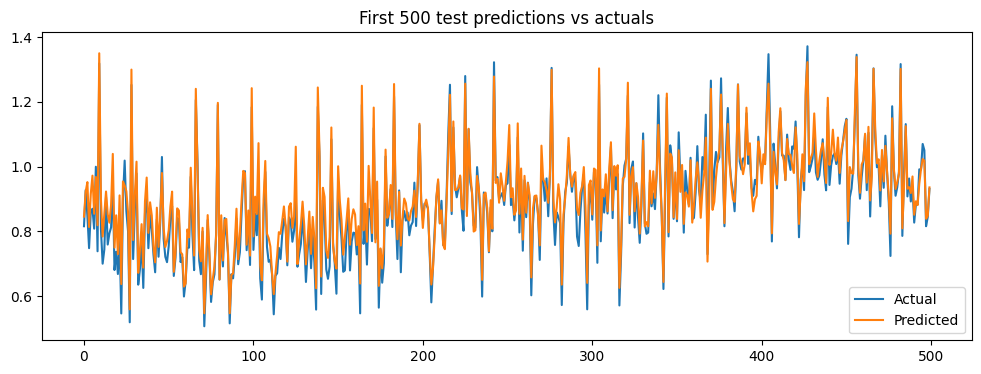

Test error l: 0.9620836544315825
Test error r: 0.19638694398341672
Test error m: 0.14112107551195108

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412296 | Test samples: 203208


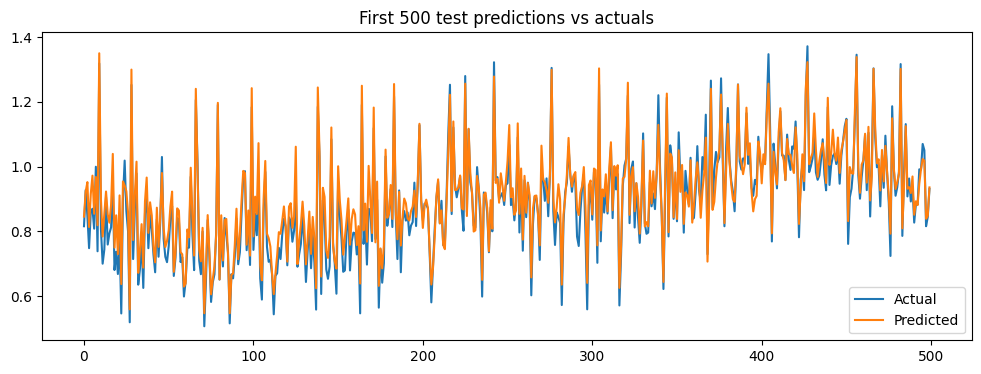

Test error l: 0.959563839512468
Test error r: -0.20926909734206078
Test error m: -0.031570521324299605

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221270


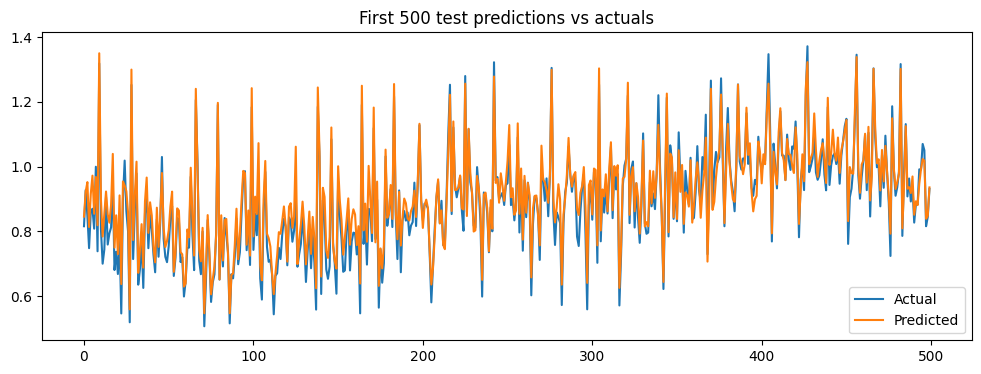

Test error l: 0.9631888676427025
Test error r: 0.2270475483881801
Test error m: 0.13705367026299753

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424478 | Test samples: 234724


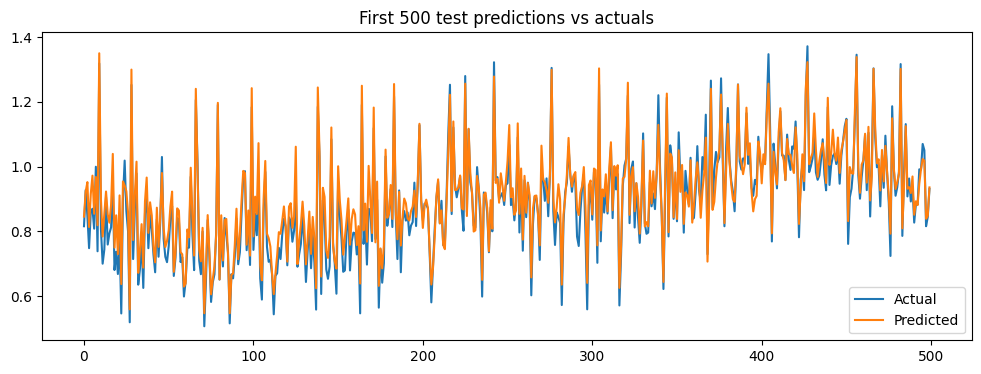

Test error l: 0.9663069791206279
Test error r: 0.1554144289022794
Test error m: 0.3815531027327058

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455994 | Test samples: 252358


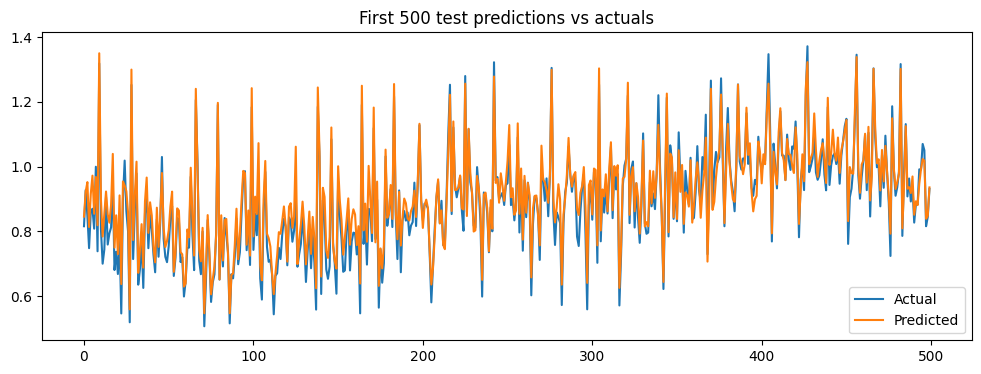

Test error l: 0.9485838378693262
Test error r: -0.6278505902021954
Test error m: -2.8100123662651444

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487082 | Test samples: 282858


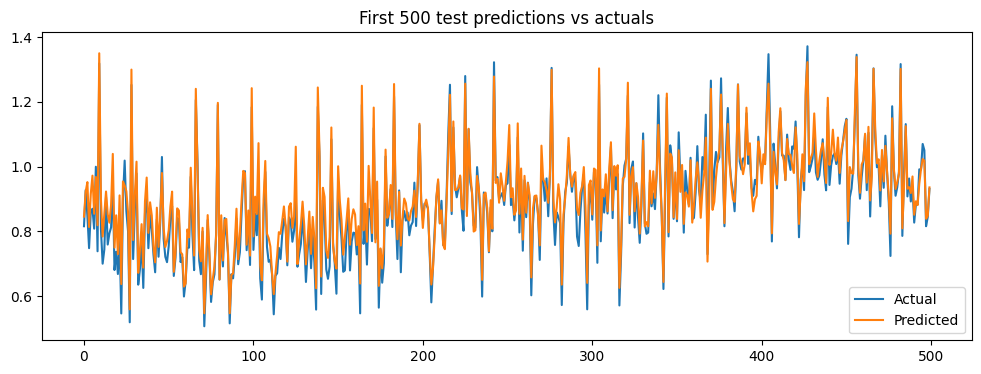

Test error l: 0.9504145736805607
Test error r: 0.23932703340480255
Test error m: 0.10909665018287906

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535216 | Test samples: 289869


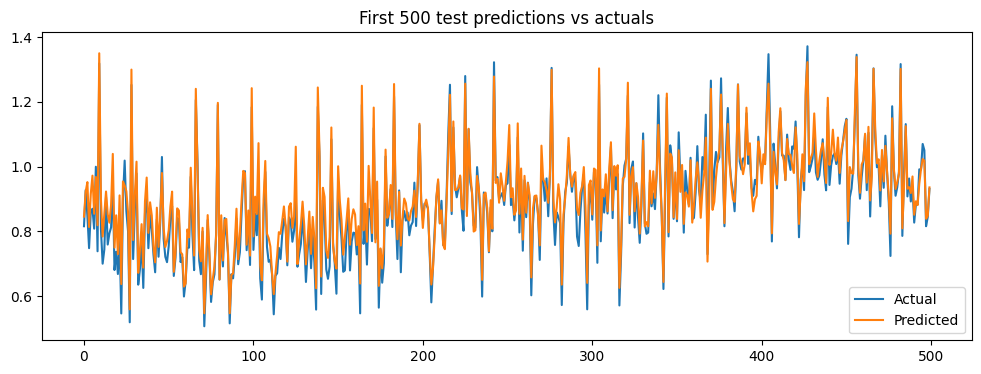

Test error l: 0.9536533581778345
Test error r: 0.11763453395149381
Test error m: 0.14192760591191567

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572727 | Test samples: 304063


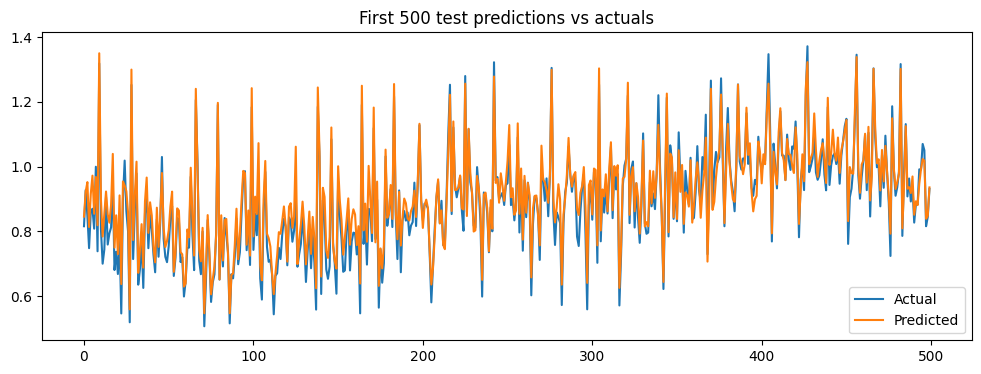

Test error l: 0.9559809807018962
Test error r: 0.11988704174738796
Test error m: 0.14334123525160314
Overall Train Metrics:
MAE: 0.026953538742911544, RMSE: 0.03755150429470014, R²: 0.9615754795803503
Overall Test Metrics:
MAE: 0.02856312456846302, RMSE: 0.040540602458942275, R²: 0.9567837953217422
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['Lag1_Consumption', 'block_6.0:tempbin', 'block_1.0:tempbin2', 'block_6.0:tempbin2', 'block_1.0:tempbin', 'Month_1', 'HourOfWeek_149', 'Month_2', 'HourOfWeek_150', 'block_2.0:tempbin', 'Month_5', 'block_2.0:tempbin2', 'Month_12', 'block_3.0:tempbin2', 'block_4.0:tempbin', 'block_1.0:Solar_MWh', 'block_4.0:tempbin2', 'PriceArea_FR', 'HourOfWeek_52', 'Price_EUA', 'HourOfWeek_100', 'HourOfWeek_76', 'HourOfWeek_28', 'HourOfWeek_148', 'Price_gas', 'HourOf

In [29]:
dml_pliv_import_1, filtered_data_import_1, importance_df_import_1, fold_metrics_df_import_1, importance_all_folds_df_import_1, fold_coefficients_import_1 = dml_rolling_window(processed_data_new, 
                                                                                                                             top_50_features, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          

In [31]:
covariates_regression = [var for var in covariates_new if var not in ['HourOfWeek_0', 'Month_1']]

In [33]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_import[outcome_var]
D = filtered_data_import[treatment_var]
Z = filtered_data_import[instrument_vars]
W = filtered_data_import[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_import[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                      0.9633
Estimator:                        IV-2SLS   Adj. R-squared:                 0.9633
No. Observations:                 1998305   F-statistic:                 9.502e+18
Date:                    Tue, Apr 22 2025   P-value (F-stat)                0.0000
Time:                            11:37:18   Distribution:                chi2(239)
Cov. Estimator:                 clustered                                         
                                                                                  
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
HourOfWeek_81           0.0346     0.0040     8.5956     0.0000      0.0

In [14]:
processed_data_new, covariates_new = prepare_data_with_dummies_and_interactions(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)
processed_data_new = processed_data_new[processed_data_new['Time'].dt.year != 2025]
processed_data_new

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
21.0                28.0 2015-01-01 02:00:00           5879.00   
19.0                20.0 2015-01-01 02:00:00          21286.00   
18.0                23.0 2015-01-01 02:00:00           1745.00   
17.0                22.0 2015-01-01 02:00:00           1236.00   
20.0                26.0 2015-01-01 02:00:00           7397.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00          10729.50   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
21.0                     20.27          5.878027          271.040405  2015   
19.0                     42.27          6.516034          278.325043  2015   
18.0                     14.60         11.060371          278.674744  2015   
17.0                     14.60         10.920368          277.208038  2015   
20.0                     35.47          3.526751          268.095337  2015   
...                        ...               ...                 ...   ...   
NaN                       4.85          5.314154          265.901459  2024   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  block_4.0:tempbin  \
Unnamed: 0.1                                    ...                      
21.0           1.0   2.0             28.202729  ...                0.0   
19.0           1.0   2.0             41.315077  ...                0.0   
18.0           1.0   2.0             41.944539  ...                0.0   
17.0           1.0   2.0             39.304469  ...                0.0   
20.0           1.0   2.0             22.901606  ...                0.0   
...            ...   ...                   ...  ...                ...   
NaN           31.0  23.0             18.952626  ...                0.0   
NaN           31.0  23.0             50.992439  ...                0.0   
NaN           31.0  23.0             39.085511  ...                0.0   
NaN           31.0  23.0             25.749757  ...                0.0   
NaN           31.0  23.0             39.424275  ...                0.0   

              block_4.0:tempbin2  block_4.0:Solar_MWh block_5.0:tempbin  \
Unnamed: 0.1                                                              
21.0                         0.0                  0.0               0.0   
19.0                         0.0                  0.0               0.0   
18.0                         0.0                  0.0               0.0   
17.0                         0.0                  0.0               0.0   
20.0                         0.0                  0.0               0.0   
...                          ...                  ...               ...   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   
NaN                          0.0                  0.0               0.0   

              block_5.0:tempbin2  block_5.0:Solar_MWh block_6.0:tempbin  \
Unnamed: 0.1                                                              
21.0                         0.0                  0


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401794 | Test samples: 209955


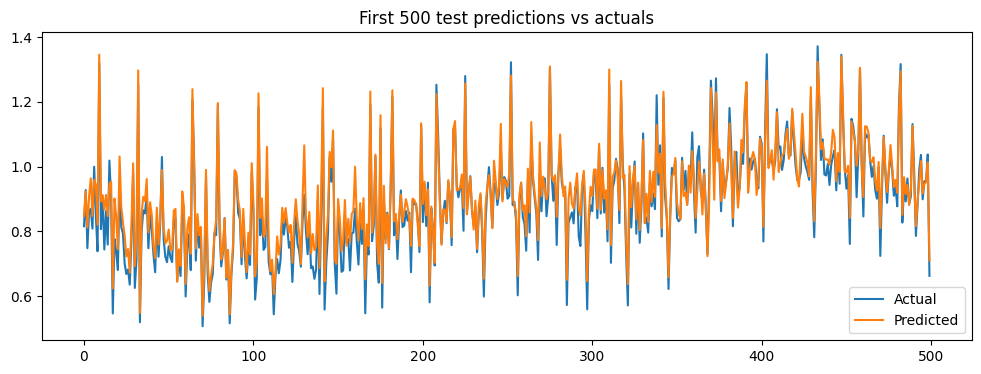

Test error l: 0.9647855932259124
Test error r: 0.2369654131788249
Test error m: 0.555638774521467

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412296 | Test samples: 203206


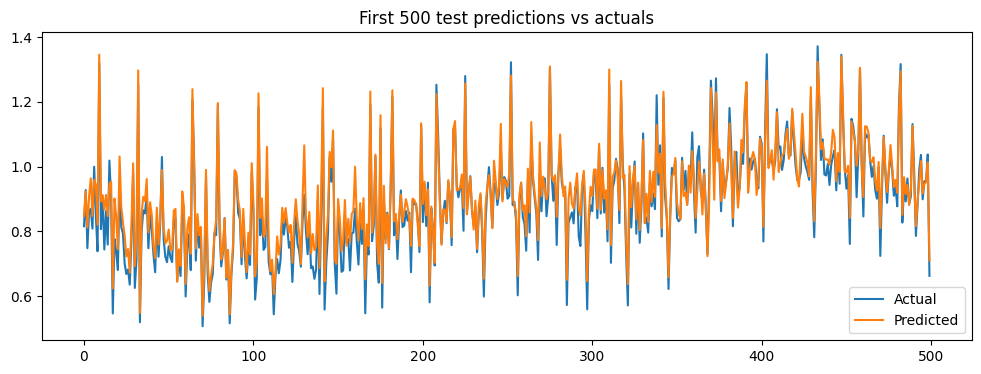

Test error l: 0.9610973243774914
Test error r: -0.002217309959254843
Test error m: 0.5918915711763929

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413161 | Test samples: 221269


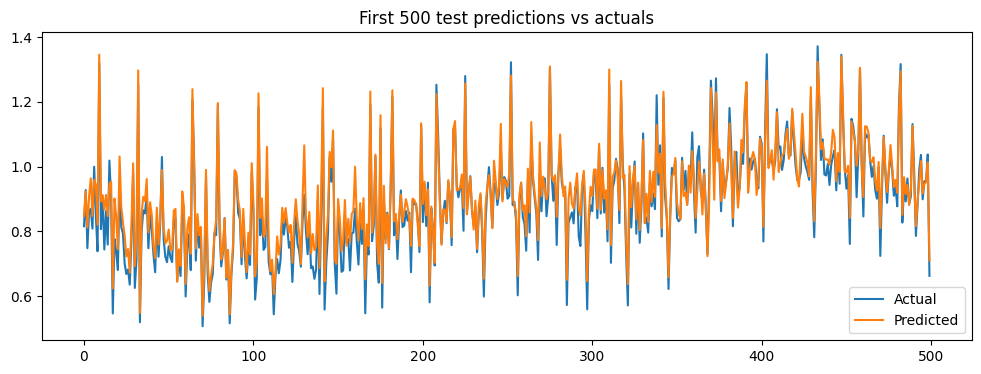

Test error l: 0.9656189418045086
Test error r: 0.2575840537491495
Test error m: 0.6031106617414183

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424475 | Test samples: 234723


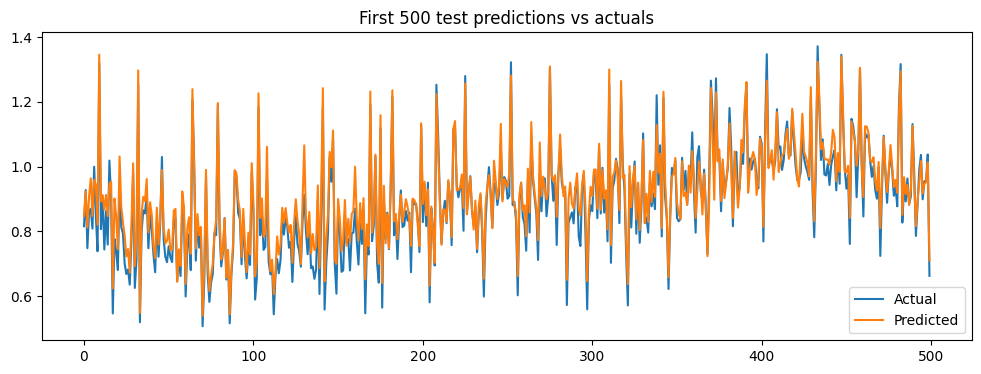

Test error l: 0.969233857643438
Test error r: 0.14325387387981914
Test error m: 0.6075411235755996

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455992 | Test samples: 243599


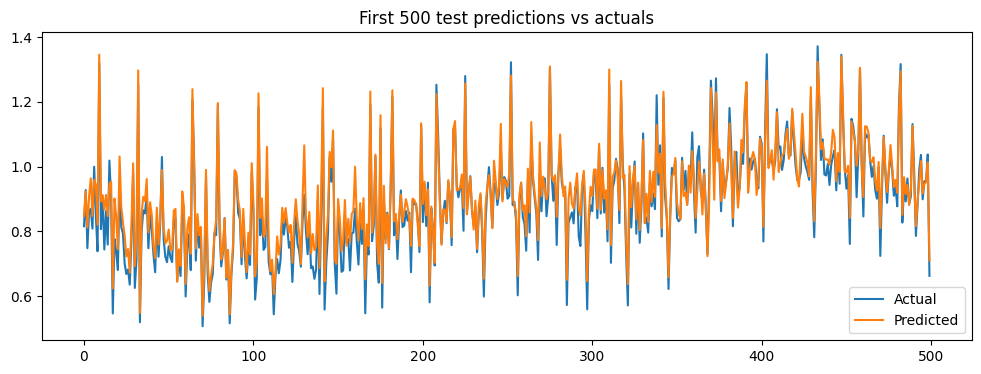

Test error l: 0.9650492725913232
Test error r: -0.6194048559122098
Test error m: 0.3615870154227333

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 478322 | Test samples: 274097


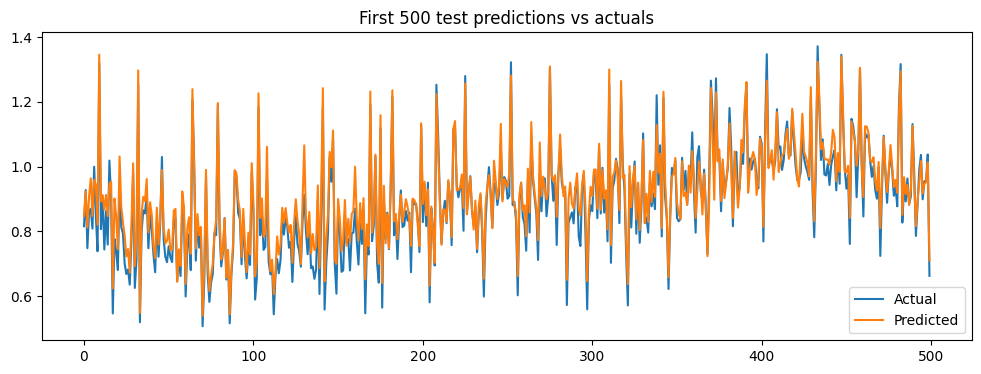

Test error l: 0.9530941739999641
Test error r: 0.31155363873815733
Test error m: 0.6363149890838815

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 517696 | Test samples: 281102


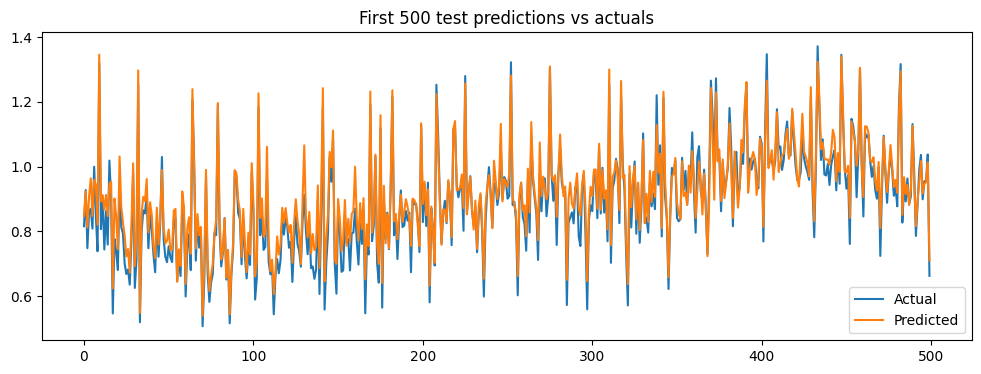

Test error l: 0.9574753165160697
Test error r: 0.19364537183319674
Test error m: 0.5774571819962961

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 555199 | Test samples: 295289


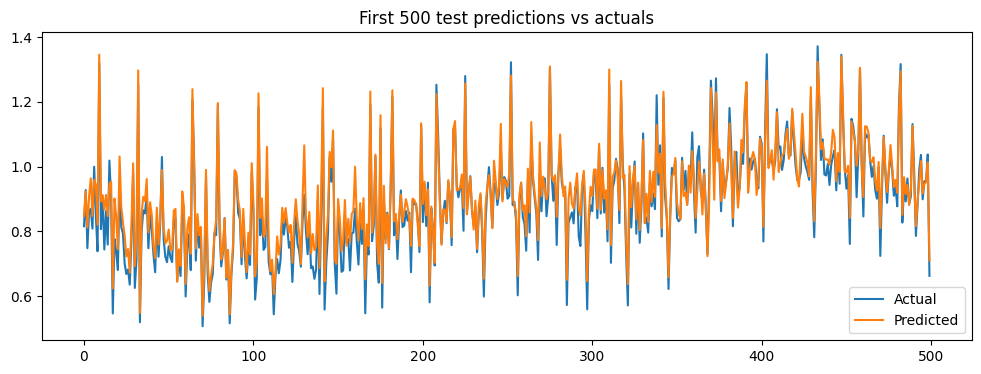

Test error l: 0.9595528921779425
Test error r: 0.15007347211220434
Test error m: 0.6206687013157952
Overall Train Metrics:
MAE: 0.025836176010113645, RMSE: 0.035553502565161516, R²: 0.9648399356144091
Overall Test Metrics:
MAE: 0.027348592220620555, RMSE: 0.0378363592455156, R²: 0.9614577213422464
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_152', 'PriceArea_LT', 'HourOfWeek_51', 'PriceArea_SE_2', 'HourOfWeek_56', 'HourOfWeek_153', 'HourOfWeek_124', 'HourOfWeek_125', 'HourOfWeek_132', 'PriceArea_SI', 'HourOfWeek_31', 'HourOfWeek_17', 'HourOfWeek_97', 'HourOfWeek_43', 'HourOfWeek_81', 'HourOfWeek_10', 'HourOfWeek_29', 'HourOfWeek_131', 'PriceArea_IT_SUD', 'HourOfWeek_111', 'HourOfWeek_5', 'Month_1', 'HourOfWeek_38', 'HourOfWeek_57', 'Price_coal', 'HourOfWeek_15', 'HourOfWeek_13

In [16]:
dml_pliv_import, filtered_data_import, importance_df_import, fold_metrics_df_import, importance_all_folds_df_import, fold_coefficients_import = dml_rolling_window(processed_data_new, 
                                                                                                                             covariates_new, 
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)
          

Test - consumption_normalized Metrics:
  MAE: 0.0273
  RMSE: 0.0378
  R²: 0.9615
consumption_normalized Range: Min = 0.0, Max = 2.4783060241355925, Range = 2.4783060241355925
MAE as percentage of range: 1.10%
RMSE as percentage of range: 1.53%


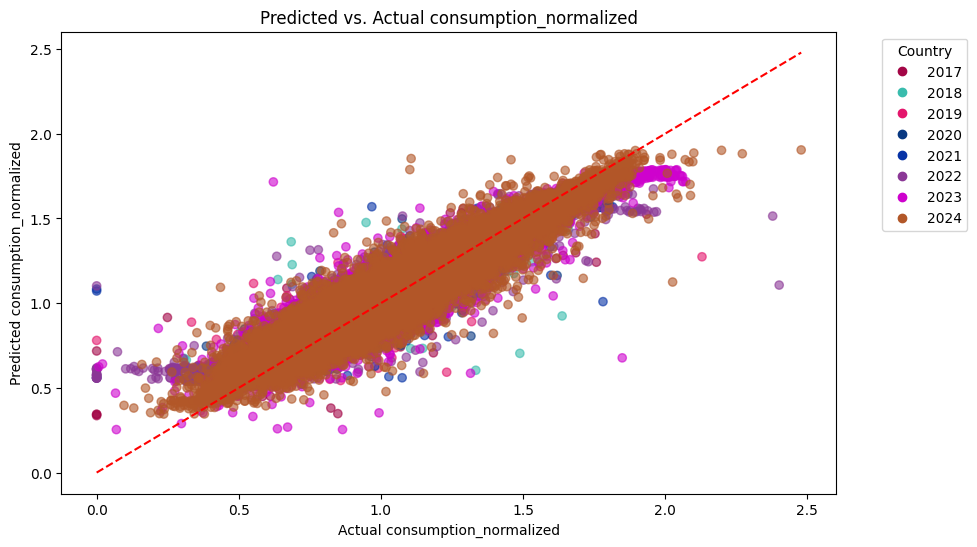

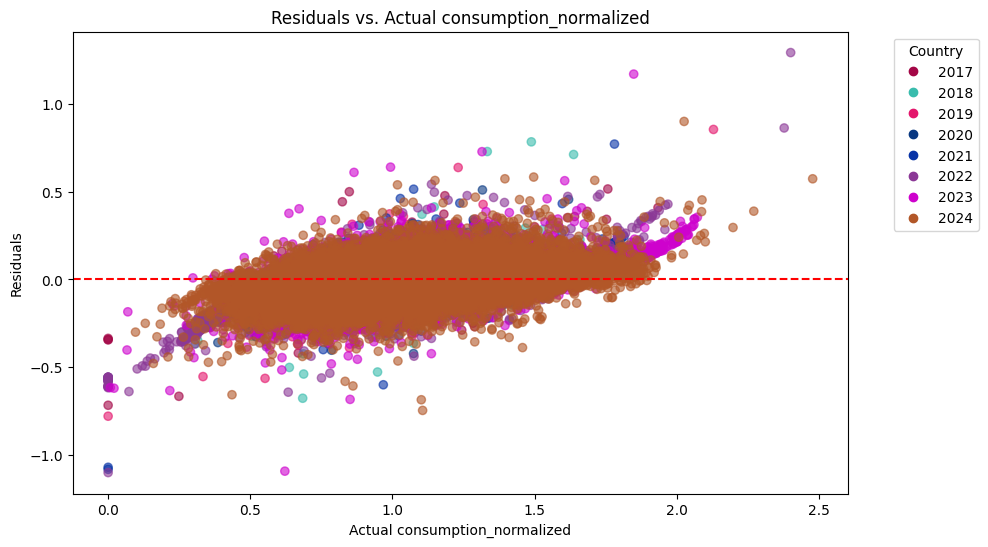

In [17]:
result = evaluate_predictions_country(
    predictions=filtered_data_import['Prrediction'],
    true_values=filtered_data_import['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_import['Year']  # Use the Country column
)

Test - consumption_normalized Metrics:
  MAE: 0.0273
  RMSE: 0.0378
  R²: 0.9615
consumption_normalized Range: Min = 0.0, Max = 2.4783060241355925, Range = 2.4783060241355925
MAE as percentage of range: 1.10%
RMSE as percentage of range: 1.53%


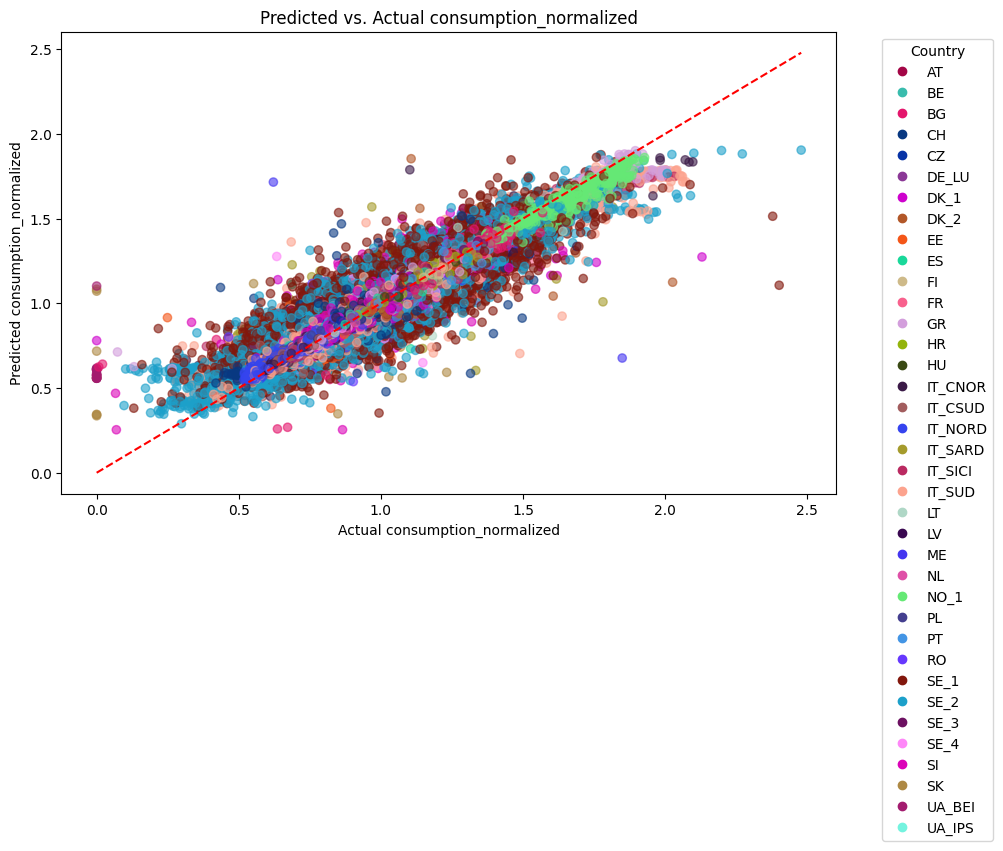

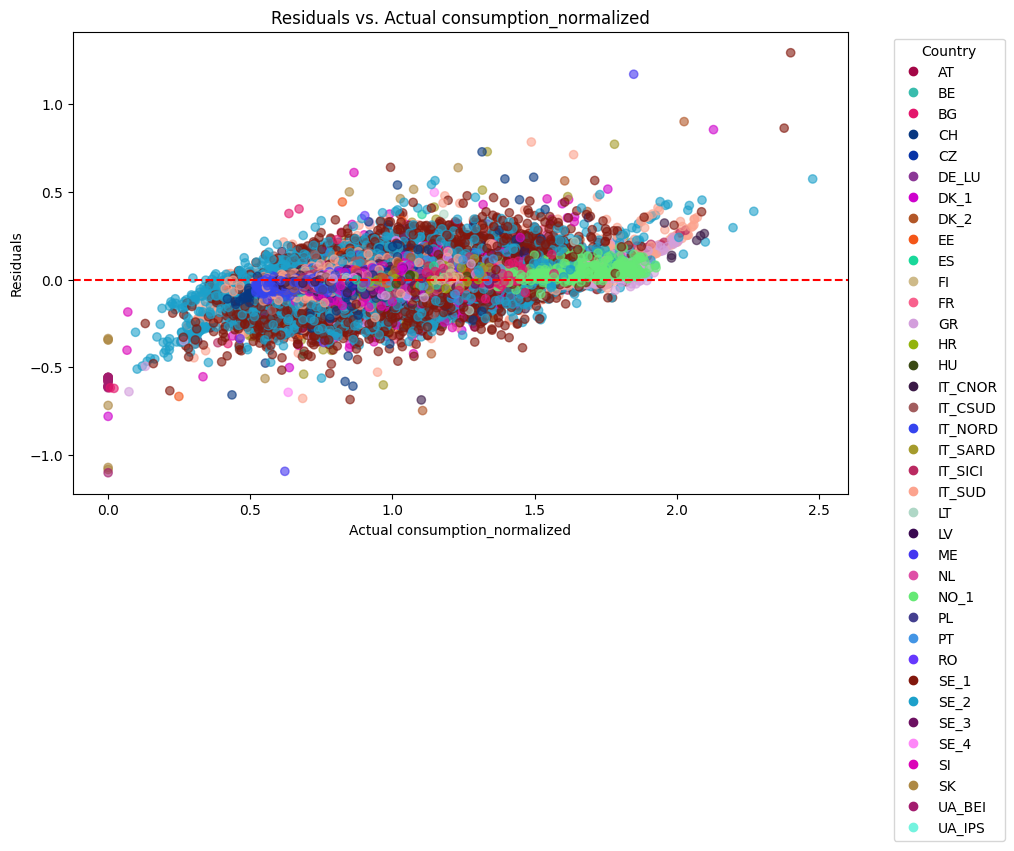

In [18]:
result = evaluate_predictions_country(
    predictions=filtered_data_import['Prrediction'],
    true_values=filtered_data_import['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_import['Country']  # Use the Country column
)

In [19]:
filtered_data_import.to_csv("lag_consumtion_df.csv", index=False)
importance_df_import.to_csv("lag_consumtion_importance.csv", index=False)
fold_coefficients_import = pd.DataFrame(fold_coefficients_import)
fold_coefficients_import.to_csv("lag_consumtion_fold_coef.csv", index=False)